# Prediction of Coronary Heart Disease

**Introduction**. World Health Organization has estimated 12 million deaths occur worldwide, every year due to Heart diseases. Half the deaths in the United States and other developed countries are due to cardio vascular diseases. The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications.  
**Task**. The task is to predict whether patient have 10 year risk of coronary heart disease (CHD) or not.  
**Source**. The dataset is publically available on the [Kaggle website](https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea), and it is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts.  
**Data description**. Each attribute in the dataset is a potential risk factor. There are both demographic, behavioral and medical risk factors.    
*Demographic*  
• `sex` – male or female (`'M'` or `'F'`);  
• `age` – age of the patient;  
• `education` – level of education;  
*Behavioral*  
• `is_smoking` – whether or not the patient is a current smoker (`'YES'` or `'NO'`);  
• `cigsPerDay` – the number of cigarettes that the person smoked on average in one day;  
*Medical (history)*  
• `BPMeds` – whether or not the patient was on blood pressure medication (`1` means “Yes”, `0` means “No”);   
• `prevalentStroke` – whether or not the patient had previously had a stroke (`1` means “Yes”, `0` means “No”);  
• `prevalentHyp` – whether or not the patient was hypertensive (`1` means “Yes”, `0` means “No”);  
• `diabetes` – whether or not the patient had diabetes (`1` means “Yes”, `0` means “No”);  
*Medical (current)*  
• `totChol` – total cholesterol level;  
• `sysBP` – systolic blood pressure;  
• `diaBP` – diastolic blood pressure;  
• `BMI` – Body Mass Index;  
• `heartRate` – heart rate;  
• `glucose` – glucose level;  
*Predict variable (desired target)*  
• `TenYearCHD` –  10 year risk of coronary heart disease CHD (`1` means “Yes”, `0` means “No”).

## Preprocessing

### Getting general information

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('~/Documents/cardiovascular.csv')
df.head()

id  age  education sex is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
0   0   64        2.0   F        YES         3.0     0.0                0   
1   1   36        4.0   M         NO         0.0     0.0                0   
2   2   46        1.0   F        YES        10.0     0.0                0   
3   3   50        1.0   M        YES        20.0     0.0                0   
4   4   64        1.0   F        YES        30.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    221.0  148.0   85.0    NaN       90.0     80.0   
1             1         0    212.0  168.0   98.0  29.77       72.0     75.0   
2             0         0    250.0  116.0   71.0  20.35       88.0     94.0   
3             1         0    233.0  158.0   88.0  28.26       68.0     94.0   
4             0         0    241.0  136.5   85.0  26.42       70.0     77.0   

   TenYearCHD  
0           1  
1           0  
2           0  
3           1  
4           0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

### Data type conversion and renaming columns

In [4]:
df = pd.get_dummies(df, columns=['sex', 'is_smoking'], drop_first=True)

In [5]:
df.rename(columns={
    'sex_M': 'sex',
    'is_smoking_YES': 'is_smoking',
    'cigsPerDay': 'cigs_per_day',
    'BPMeds': 'BP_meds',
    'prevalentStroke': 'prev_stroke',
    'prevalentHyp': 'prev_hyp',
    'totChol': 'tot_chol',
    'sysBP': 'sys_BP',
    'diaBP': 'dia_BP',
    'heartRate': 'heart_rate',
    'TenYearCHD': 'ten_year_CHD'
}, inplace=True)

df.head()

id  age  education  cigs_per_day  BP_meds  prev_stroke  prev_hyp  diabetes  \
0   0   64        2.0           3.0      0.0            0         0         0   
1   1   36        4.0           0.0      0.0            0         1         0   
2   2   46        1.0          10.0      0.0            0         0         0   
3   3   50        1.0          20.0      0.0            0         1         0   
4   4   64        1.0          30.0      0.0            0         0         0   

   tot_chol  sys_BP  dia_BP    BMI  heart_rate  glucose  ten_year_CHD  sex  \
0     221.0   148.0    85.0    NaN        90.0     80.0             1    0   
1     212.0   168.0    98.0  29.77        72.0     75.0             0    1   
2     250.0   116.0    71.0  20.35        88.0     94.0             0    0   
3     233.0   158.0    88.0  28.26        68.0     94.0             1    1   
4     241.0   136.5    85.0  26.42        70.0     77.0             0    0   

   is_smoking  
0           1  
1           0  
2           1  
3           1  
4           1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3390 non-null   int64  
 1   age           3390 non-null   int64  
 2   education     3303 non-null   float64
 3   cigs_per_day  3368 non-null   float64
 4   BP_meds       3346 non-null   float64
 5   prev_stroke   3390 non-null   int64  
 6   prev_hyp      3390 non-null   int64  
 7   diabetes      3390 non-null   int64  
 8   tot_chol      3352 non-null   float64
 9   sys_BP        3390 non-null   float64
 10  dia_BP        3390 non-null   float64
 11  BMI           3376 non-null   float64
 12  heart_rate    3389 non-null   float64
 13  glucose       3086 non-null   float64
 14  ten_year_CHD  3390 non-null   int64  
 15  sex           3390 non-null   uint8  
 16  is_smoking    3390 non-null   uint8  
dtypes: float64(9), int64(6), uint8(2)
memory usage: 404.0 KB


### Check for duplicates

In [7]:
df['id'].duplicated().sum()

0

In [8]:
df.drop(['id'], axis=1, inplace=True)

### Missing values analysis

In [9]:
df.isna().mean().sort_values()

age             0.000000
prev_stroke     0.000000
prev_hyp        0.000000
diabetes        0.000000
sys_BP          0.000000
dia_BP          0.000000
ten_year_CHD    0.000000
sex             0.000000
is_smoking      0.000000
heart_rate      0.000295
BMI             0.004130
cigs_per_day    0.006490
tot_chol        0.011209
BP_meds         0.012979
education       0.025664
glucose         0.089676
dtype: float64

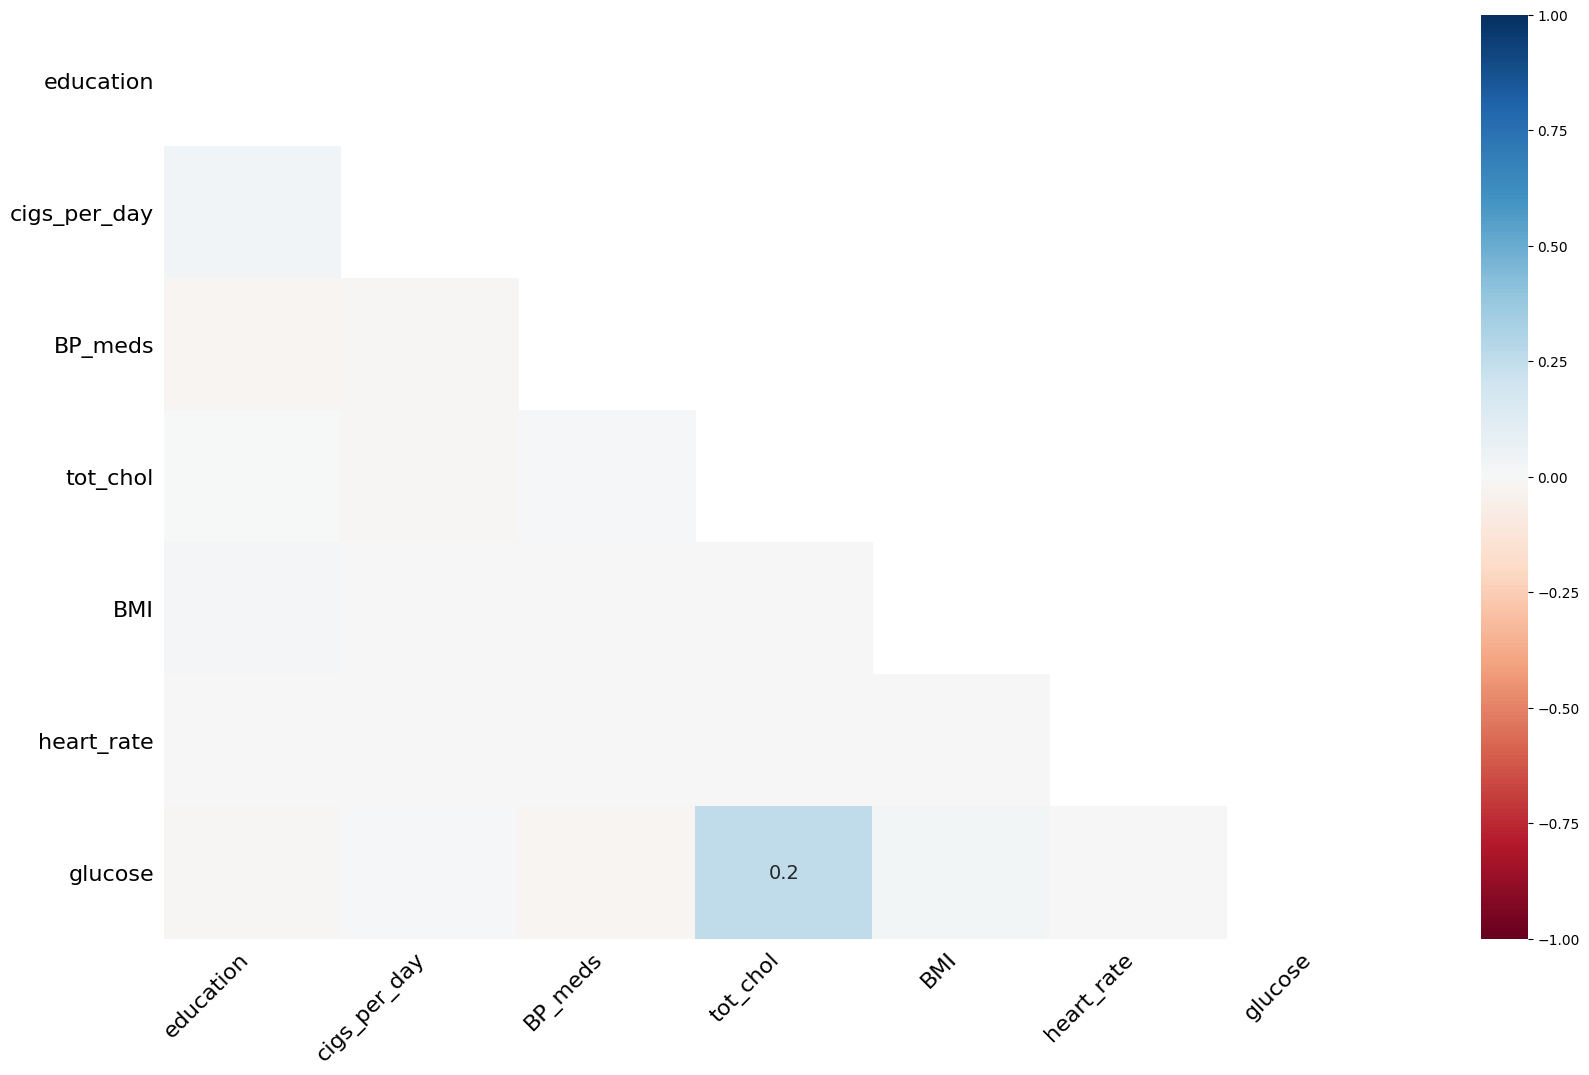

In [10]:
msno.heatmap(df);

In [11]:
sns.set_style('darkgrid') 

def na_dist(na_col):
    fig, axs = plt.subplots(5,3, figsize=(12, 17))
    axs = axs.ravel()
    i=0
    for column in df.columns: 
        if column == na_col: continue
        sns.histplot(
                ax=axs[i],
                data=df,
                x=column,
                hue=df[na_col].isna(),
                stat='probability',
                common_norm=False,
                palette='seismic'
            )
        axs[i].legend(title=f'{na_col}', labels=['n/a', 'non n/a'])
        i+=1

#### education

In [12]:
df['education'].isna().sum()

87

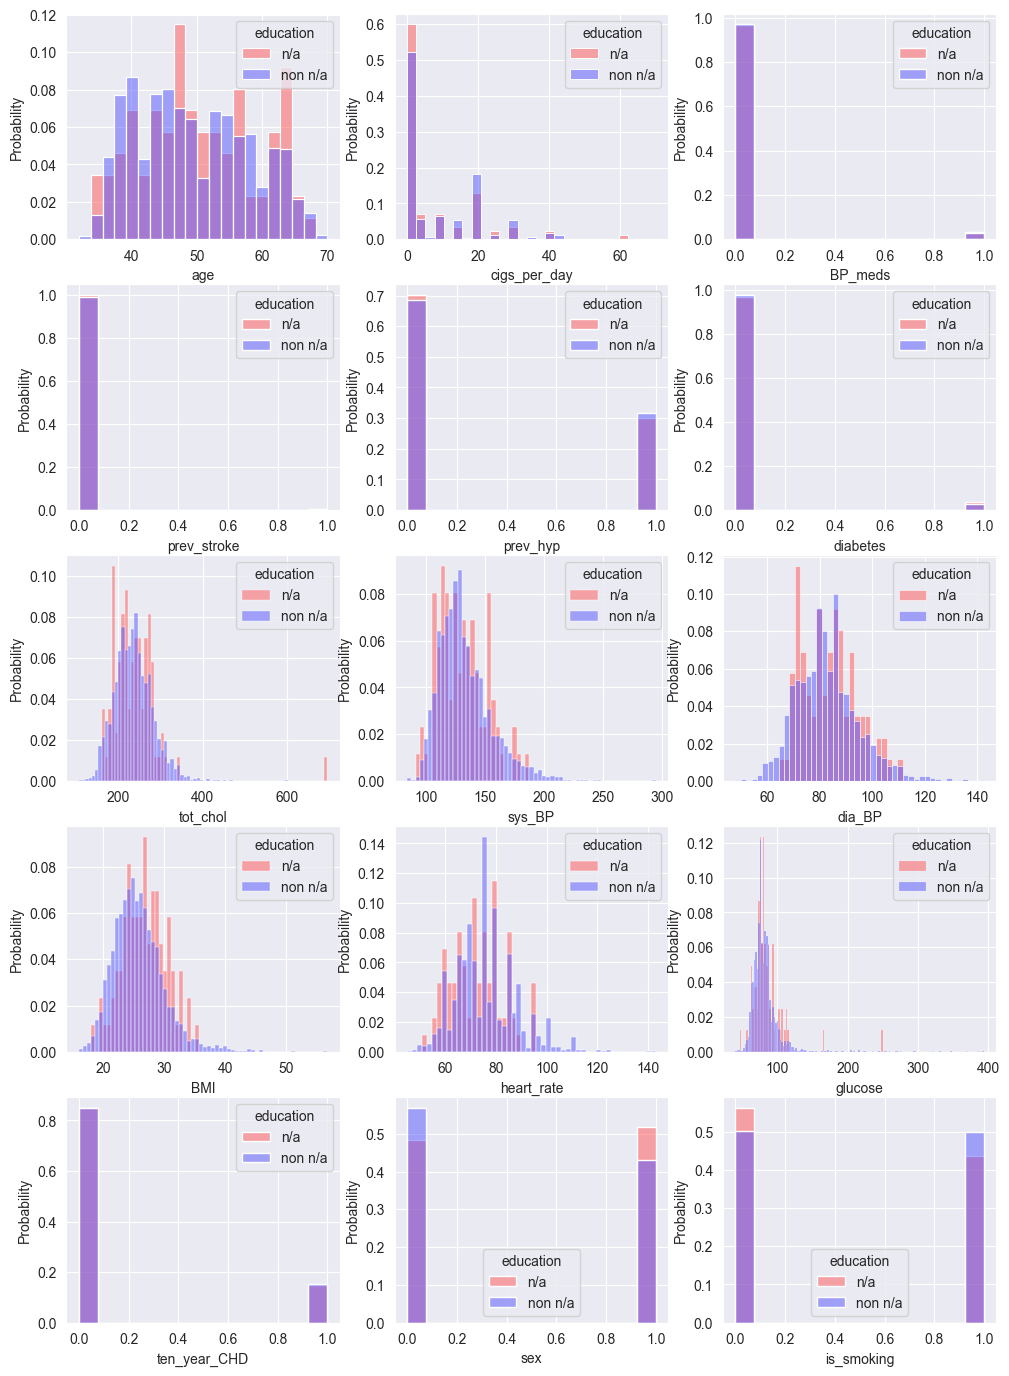

In [13]:
na_dist('education')

In [14]:
df['education'].unique()

array([ 2.,  4.,  1.,  3., nan])

In [15]:
df['education'].fillna(0, inplace=True)
df['education'].unique()

array([2., 4., 1., 3., 0.])

#### cigs_per_day

In [16]:
df['cigs_per_day'].isna().sum()

22

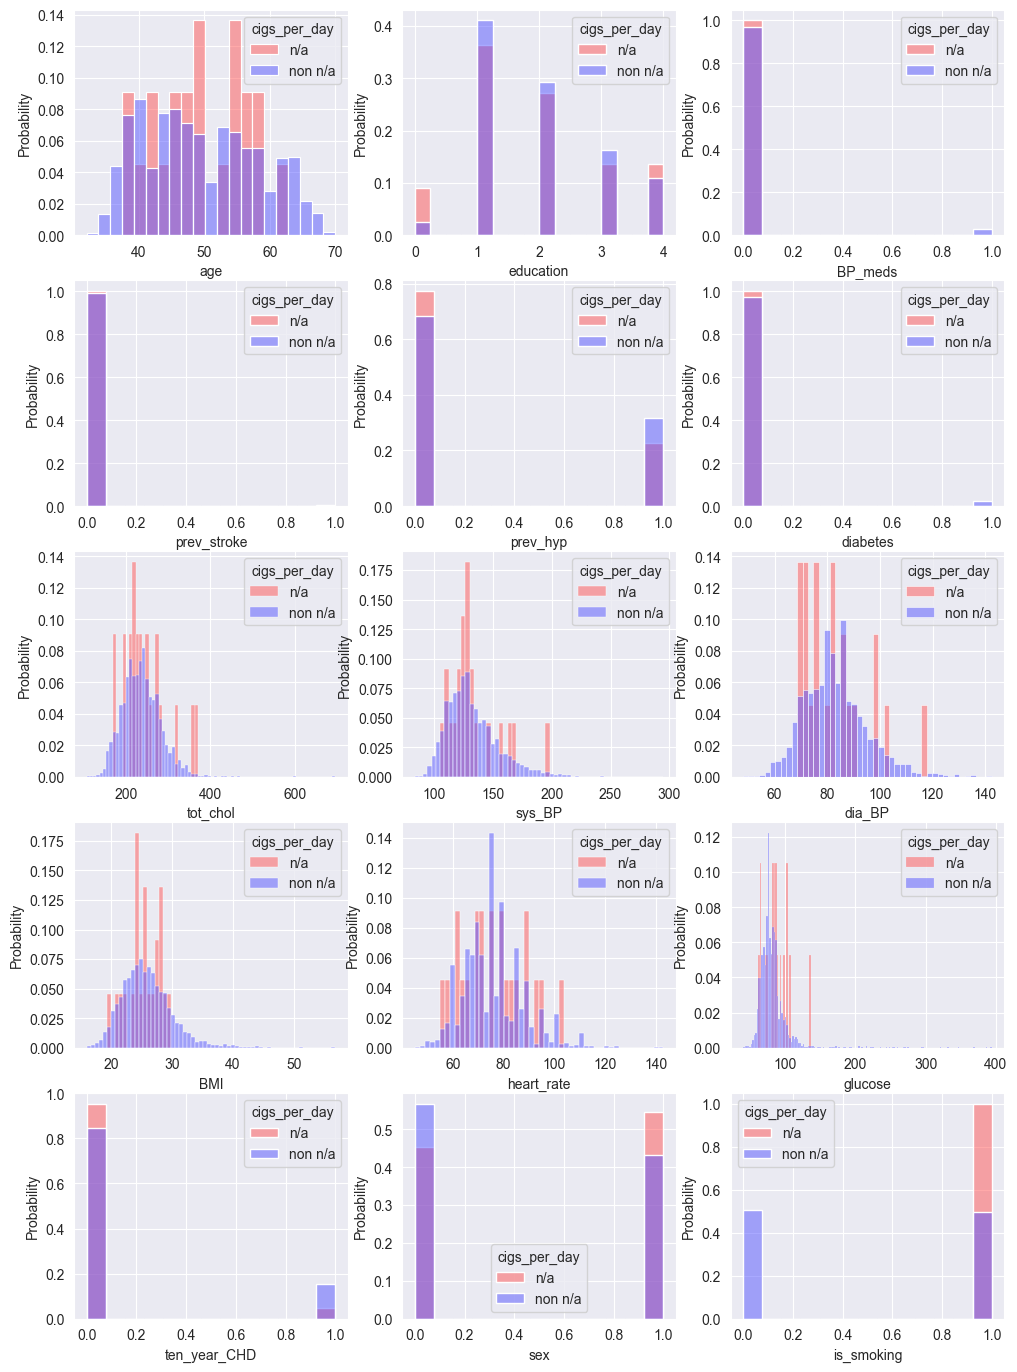

In [17]:
na_dist('cigs_per_day')

In [18]:
df[df['cigs_per_day'].isna()]['is_smoking'].unique()

array([1], dtype=uint8)

#### BP_meds

In [19]:
df['BP_meds'].isna().sum()

44

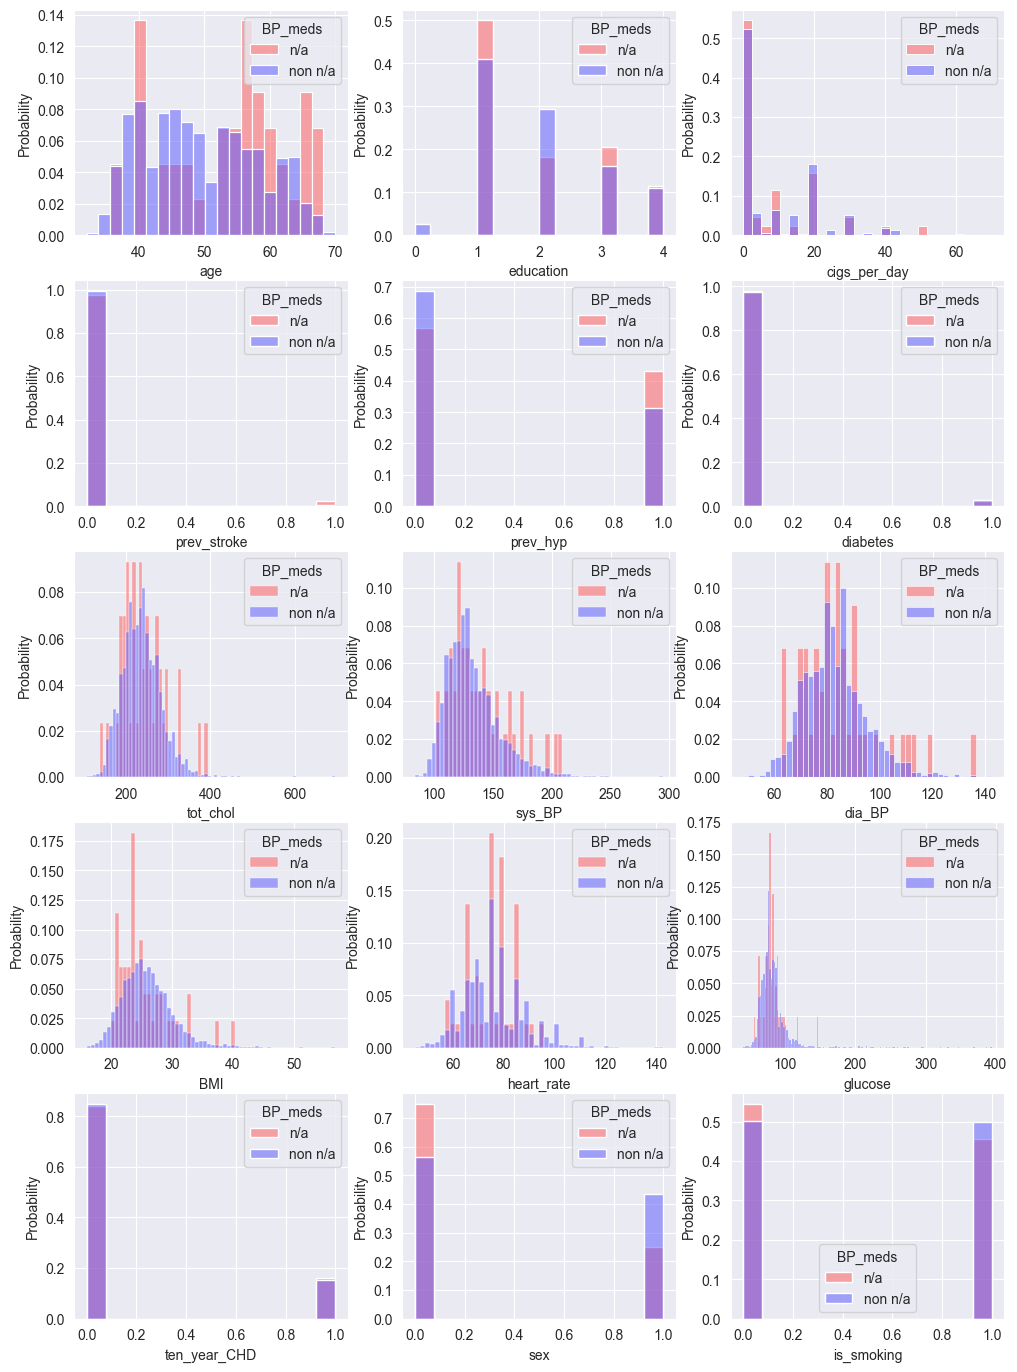

In [20]:
na_dist('BP_meds')

#### tot_chol

In [21]:
df['tot_chol'].isna().sum()

38

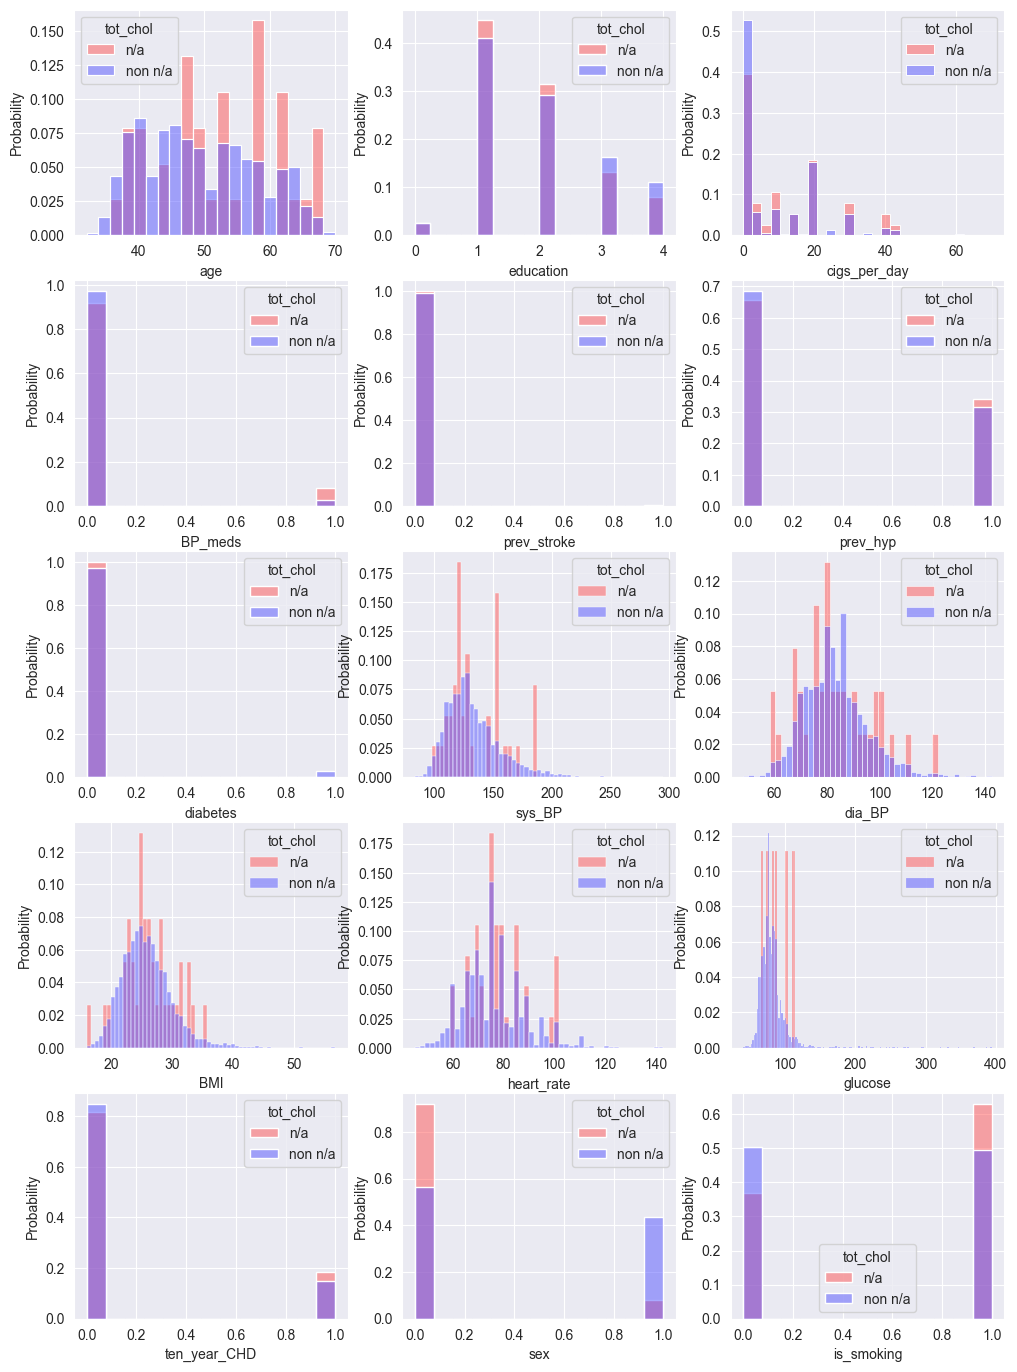

In [22]:
na_dist('tot_chol')

#### BMI

In [23]:
df['BMI'].isna().sum()

14

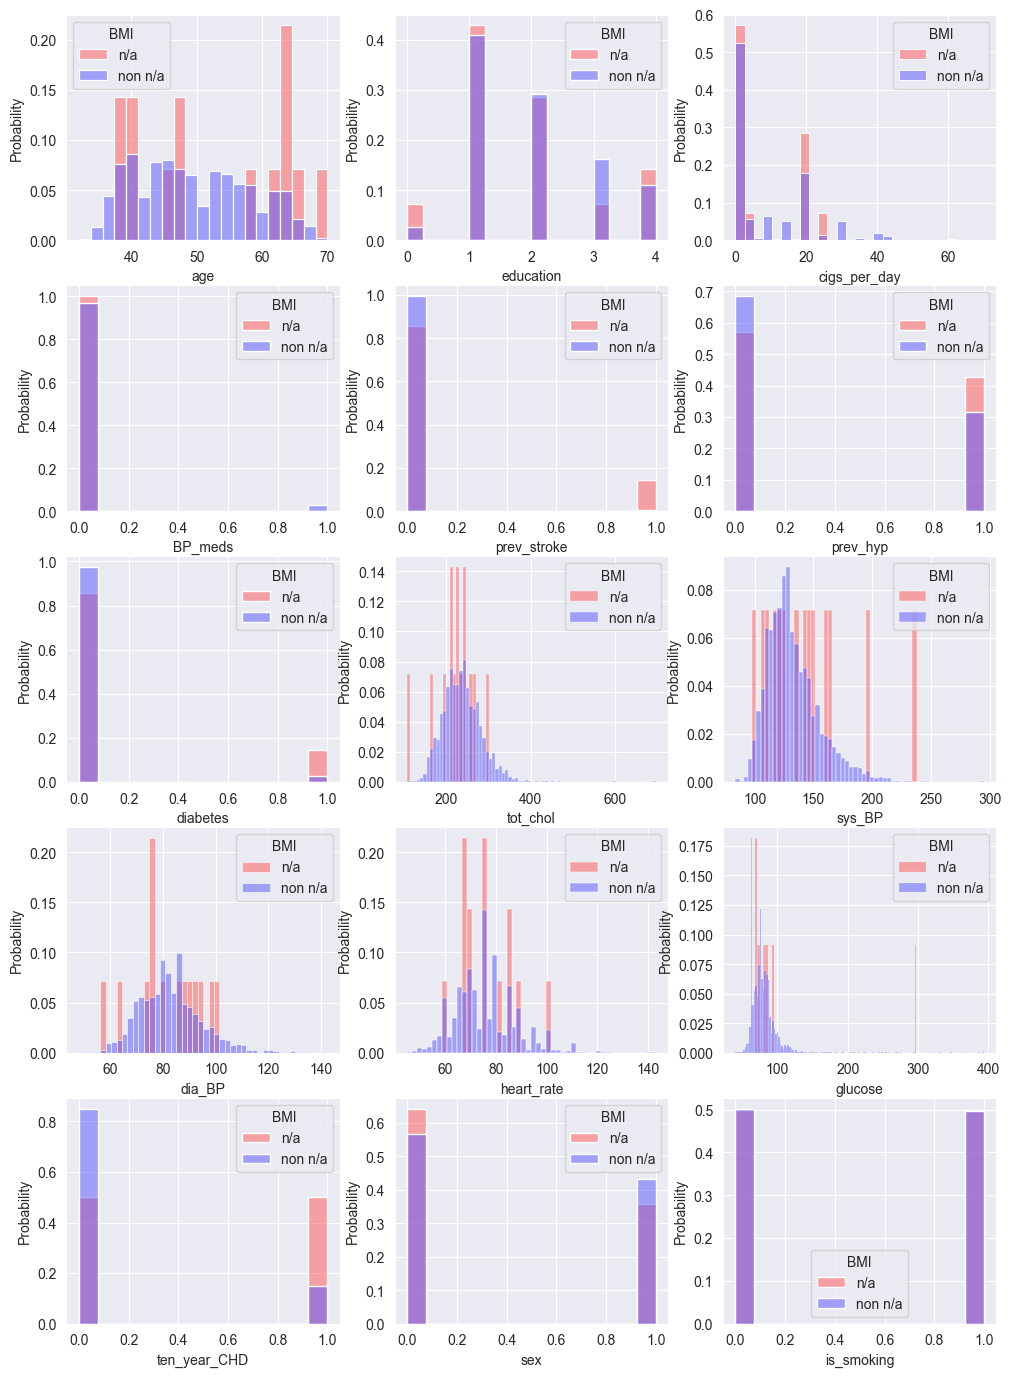

In [24]:
na_dist('BMI')

#### heart_rate 

In [25]:
df['heart_rate'].isna().sum()

1

#### glucose

In [26]:
df['glucose'].isna().sum()

304

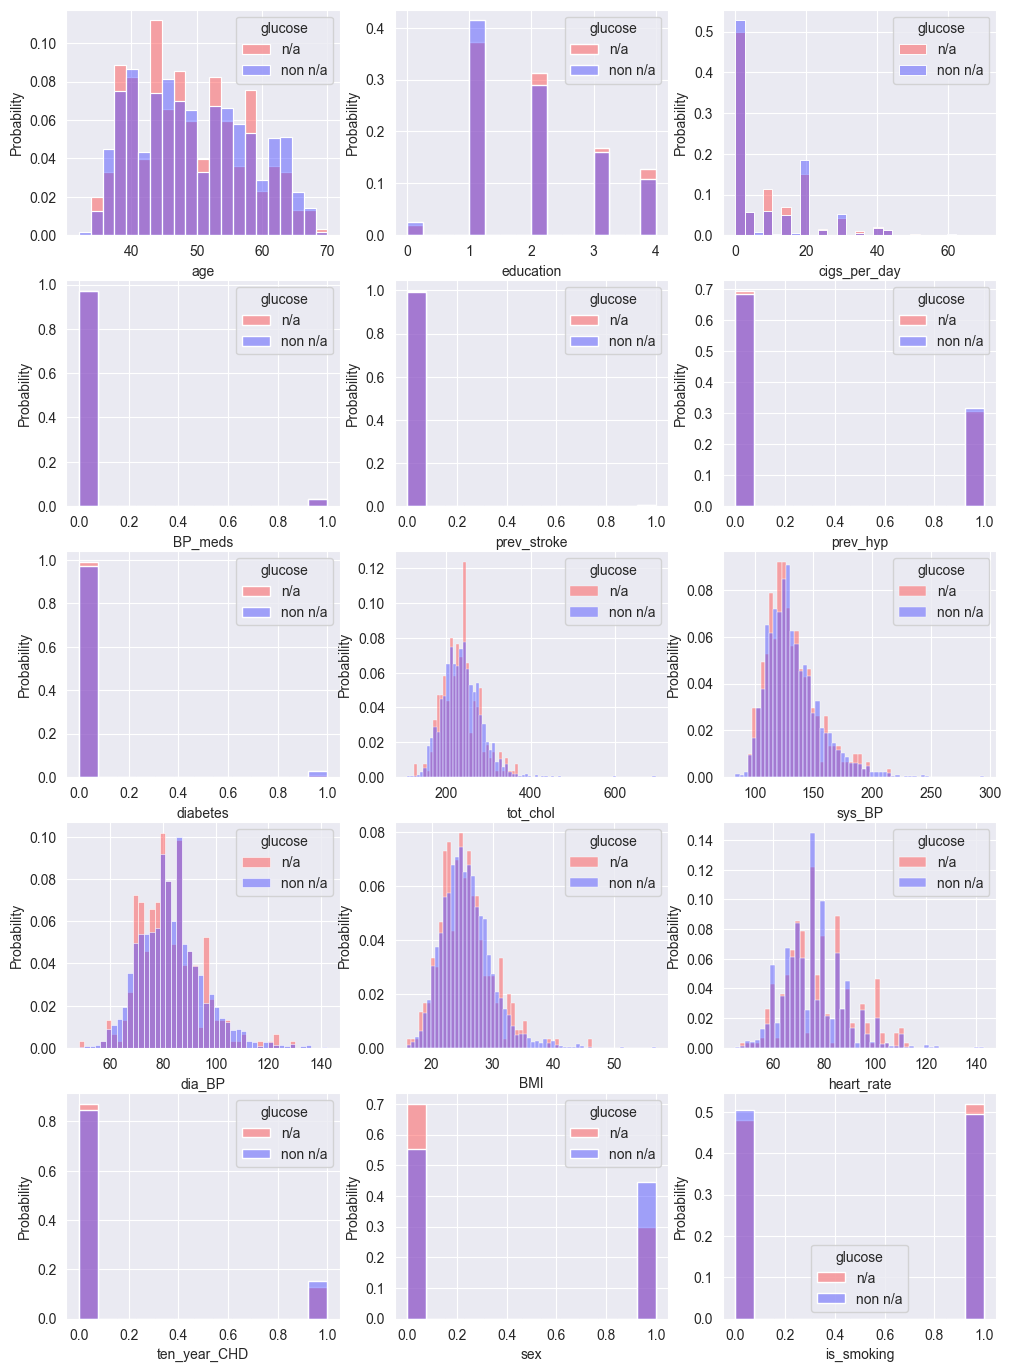

In [27]:
na_dist('glucose')

## EDA

In [28]:
def eda_graphs(df, column, binwidth=None, discrete=None, kde=True):
    fig, ax = plt.subplots(1,2, figsize=(12, 4))
    sns.histplot(
        data=df,
        x=column,
        stat='probability',
        common_norm=False,
        palette='seismic',
        kde=kde,
        discrete=discrete,
        binwidth=binwidth,
        ax=ax[0]
    ).set(title=f'General distribution of {column}')
    sns.histplot(
        data=df,
        x=column,
        hue='ten_year_CHD',
        stat='probability',
        common_norm=False,
        palette='seismic',
        kde=kde,
        discrete=discrete,
        binwidth=binwidth,
        ax=ax[1]
    ).set(title=f'Distribution of {column} by ten year CHD')
    plt.show()
    return

In [29]:
def descr_cont(data):
    table = pd.DataFrame(
        {
            'General': df[data].describe(percentiles=[.01, .5, .99]).round(1),
            'CHD': df.query('ten_year_CHD == 1')[data].describe(percentiles=[.01, .5, .99]).round(1),
            'non CHD': df.query('ten_year_CHD == 0')[data].describe(percentiles=[.01, .5, .99]).round(1),
        }

    )
    return table

In [30]:
def descr_cat(data):
    table_overall = df.pivot_table(index=data, values='age', aggfunc='count')
    table_by_chd = df.pivot_table(index=data, columns='ten_year_CHD', values='age', aggfunc='count')
    table = table_overall.join(table_by_chd)
    table.columns=['overall', 'non CHD', 'CHD']
    table['CHD_rate, %'] = (table['CHD'] / table['overall']).mul(100).round(1)
    table['overal, %'] = (table['overall'] / table['overall'].sum()).mul(100).round(1)
    table['non CHD, %'] = (table['non CHD'] / table['non CHD'].sum()).mul(100).round(1)
    table['CHD, %'] = (table['CHD'] / table['CHD'].sum()).mul(100).round(1)
    
    return table

### Descriptive Statistics

#### Ten year risk of coronary heart disease

In [31]:
CHD_proportion = df['ten_year_CHD'].value_counts().reset_index()
CHD_proportion = CHD_proportion.replace({'index': {0: 'non CHD', 1: 'CHD'}})

fig = px.pie(
    CHD_proportion, 
    values='ten_year_CHD', 
    names='index', 
    color_discrete_sequence=['#0088C8', '#FF6633'], 
    opacity=0.8,
    width=700, height=500
)

fig.update_layout(title='The ratio between CHD and non-CHD patients')
fig.update_traces(textinfo='percent+value')

fig.show()

#### Age

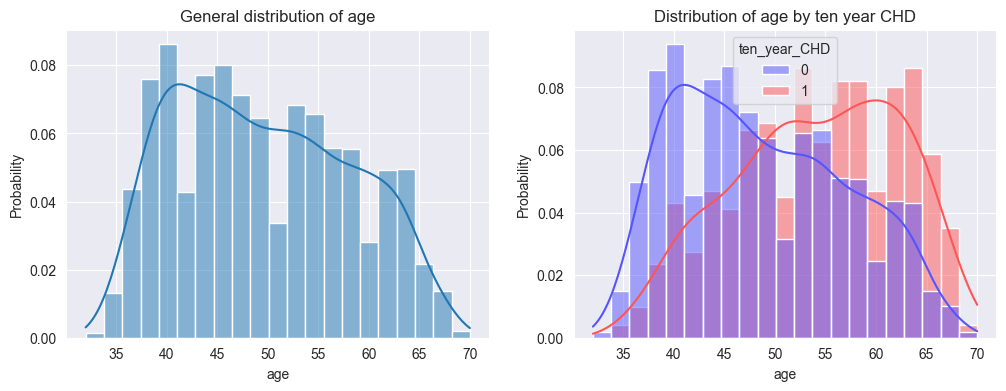

In [32]:
eda_graphs(df, 'age')

In [33]:
descr_cont('age')

General    CHD  non CHD
count   3390.0  511.0   2879.0
mean      49.5   54.1     48.7
std        8.6    8.1      8.4
min       32.0   35.0     32.0
1%        35.0   37.0     35.0
50%       49.0   55.0     48.0
99%       67.0   68.0     67.0
max       70.0   70.0     70.0

#### Sex

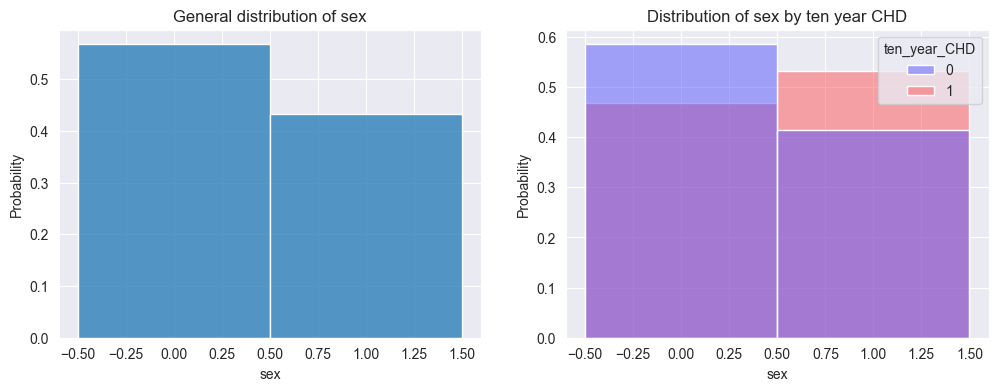

In [34]:
eda_graphs(df, 'sex', discrete=True, kde=False)

In [35]:
descr_cat('sex')

overall  non CHD  CHD  CHD_rate, %  overal, %  non CHD, %  CHD, %
sex                                                                   
0       1923     1684  239         12.4       56.7        58.5    46.8
1       1467     1195  272         18.5       43.3        41.5    53.2

#### Education

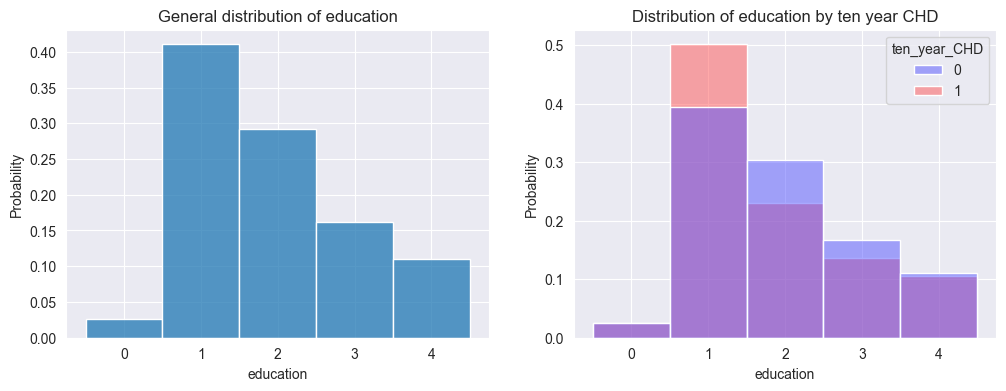

In [36]:
eda_graphs(df, 'education', discrete=True, kde=False)

In [37]:
descr_cat('education')

overall  non CHD  CHD  CHD_rate, %  overal, %  non CHD, %  CHD, %
education                                                                   
0.0             87       74   13         14.9        2.6         2.6     2.5
1.0           1391     1135  256         18.4       41.0        39.4    50.1
2.0            990      872  118         11.9       29.2        30.3    23.1
3.0            549      479   70         12.8       16.2        16.6    13.7
4.0            373      319   54         14.5       11.0        11.1    10.6

#### Cigarettes per day

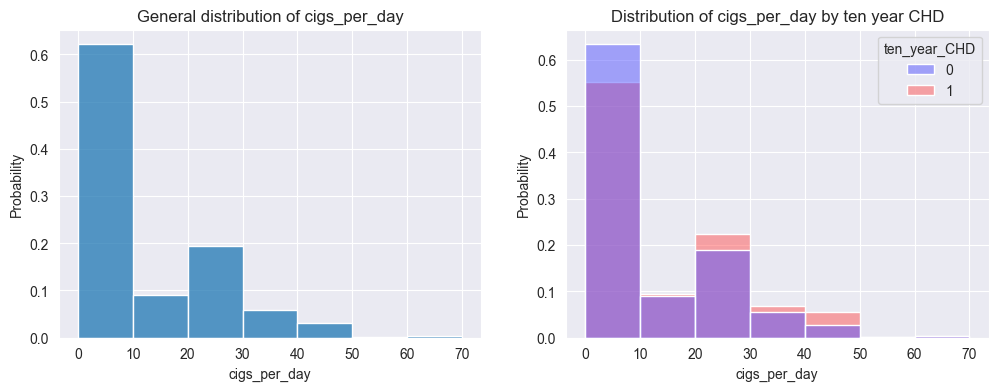

In [38]:
eda_graphs(df, 'cigs_per_day', binwidth=10, kde=False)

In [39]:
descr_cont('cigs_per_day')

General    CHD  non CHD
count   3368.0  510.0   2858.0
mean       9.1   10.9      8.7
std       11.9   13.1     11.6
min        0.0    0.0      0.0
1%         0.0    0.0      0.0
50%        0.0    4.0      0.0
99%       43.0   43.0     43.0
max       70.0   60.0     70.0

#### Smoking

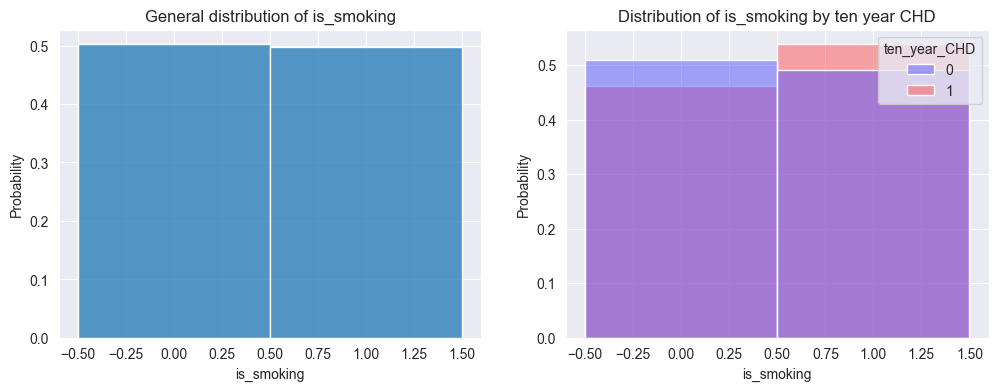

In [40]:
eda_graphs(df, 'is_smoking', discrete=True, kde=False)

In [41]:
descr_cat('is_smoking')

overall  non CHD  CHD  CHD_rate, %  overal, %  non CHD, %  CHD, %
is_smoking                                                                   
0              1703     1467  236         13.9       50.2        51.0    46.2
1              1687     1412  275         16.3       49.8        49.0    53.8

#### Blood Pressure medication

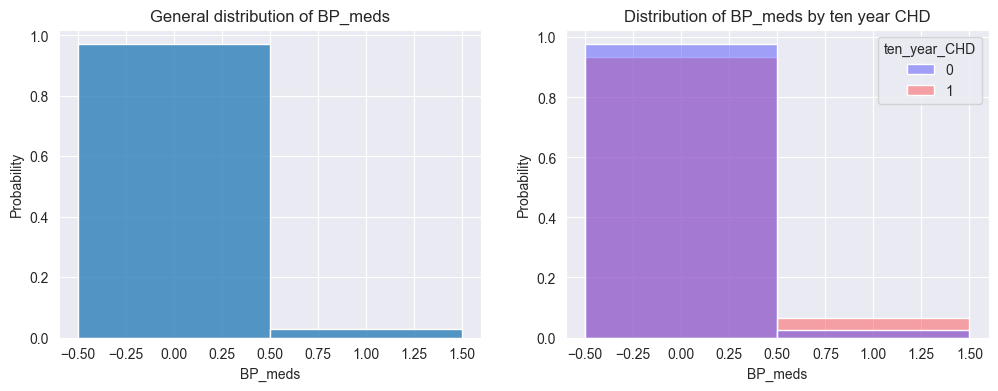

In [42]:
eda_graphs(df, 'BP_meds', discrete=True, kde=False)

In [43]:
descr_cat('BP_meds')

overall  non CHD  CHD  CHD_rate, %  overal, %  non CHD, %  CHD, %
BP_meds                                                                   
0.0         3246     2775  471         14.5       97.0        97.6    93.5
1.0          100       67   33         33.0        3.0         2.4     6.5

#### Previous Stroke

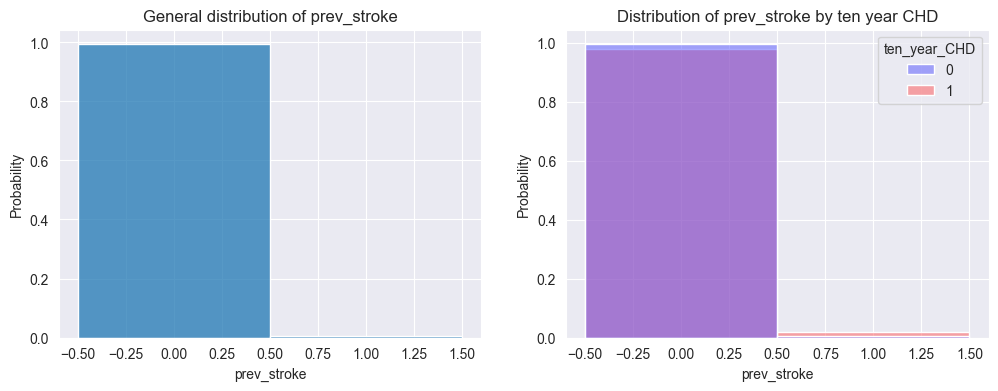

In [44]:
eda_graphs(df, 'prev_stroke', discrete=True, kde=False)

In [45]:
descr_cat('prev_stroke')

overall  non CHD  CHD  CHD_rate, %  overal, %  non CHD, %  CHD, %
prev_stroke                                                                   
0               3368     2867  501         14.9       99.4        99.6    98.0
1                 22       12   10         45.5        0.6         0.4     2.0

#### Hypertension

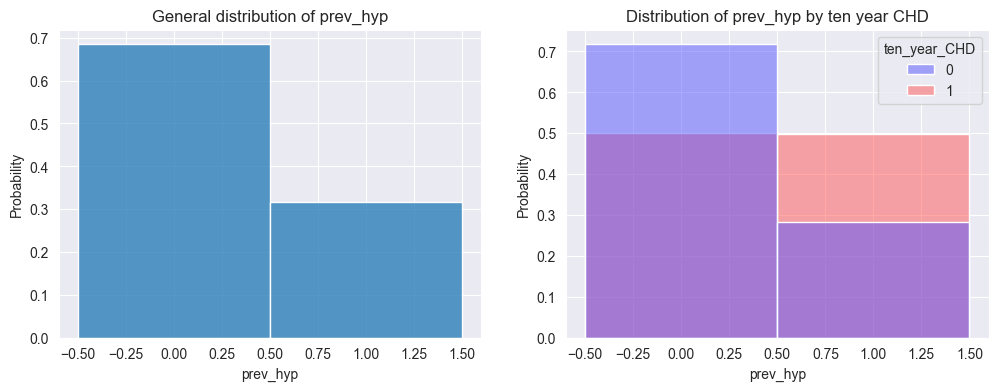

In [46]:
eda_graphs(df, 'prev_hyp', discrete=True, kde=False)

In [47]:
descr_cat('prev_hyp')

overall  non CHD  CHD  CHD_rate, %  overal, %  non CHD, %  CHD, %
prev_hyp                                                                   
0            2321     2065  256         11.0       68.5        71.7    50.1
1            1069      814  255         23.9       31.5        28.3    49.9

#### Diabetes

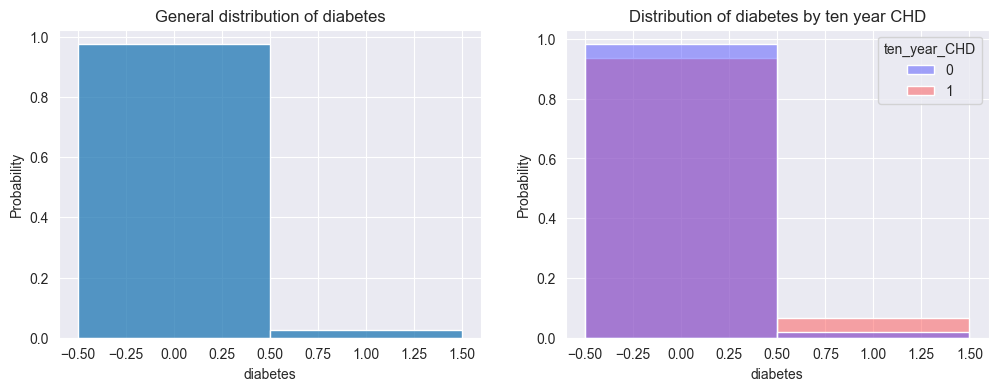

In [48]:
eda_graphs(df, 'diabetes', discrete=True, kde=False)

In [49]:
descr_cat('diabetes')

overall  non CHD  CHD  CHD_rate, %  overal, %  non CHD, %  CHD, %
diabetes                                                                   
0            3303     2825  478         14.5       97.4        98.1    93.5
1              87       54   33         37.9        2.6         1.9     6.5

#### Total Cholesterol level

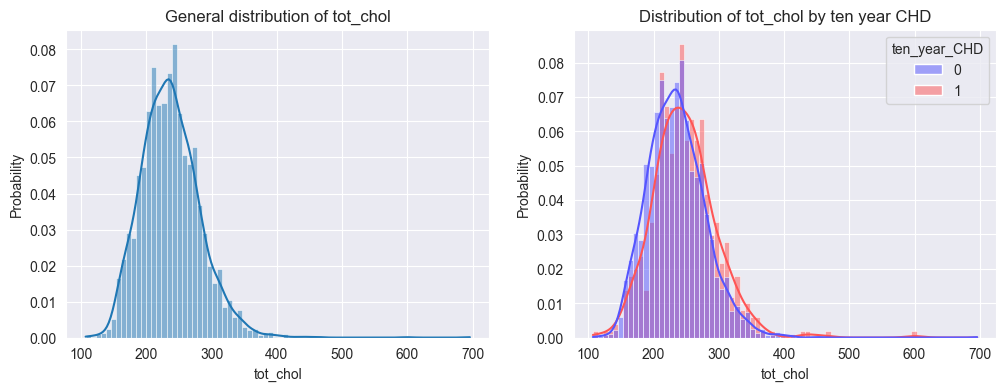

In [50]:
eda_graphs(df, 'tot_chol')

In [51]:
descr_cont('tot_chol')

General    CHD  non CHD
count   3352.0  504.0   2848.0
mean     237.1  247.2    235.3
std       45.2   49.5     44.2
min      107.0  107.0    113.0
1%       153.0  156.0    153.0
50%      234.0  243.0    232.0
99%      355.5  369.7    352.0
max      696.0  600.0    696.0

#### Systolic Blood pressure

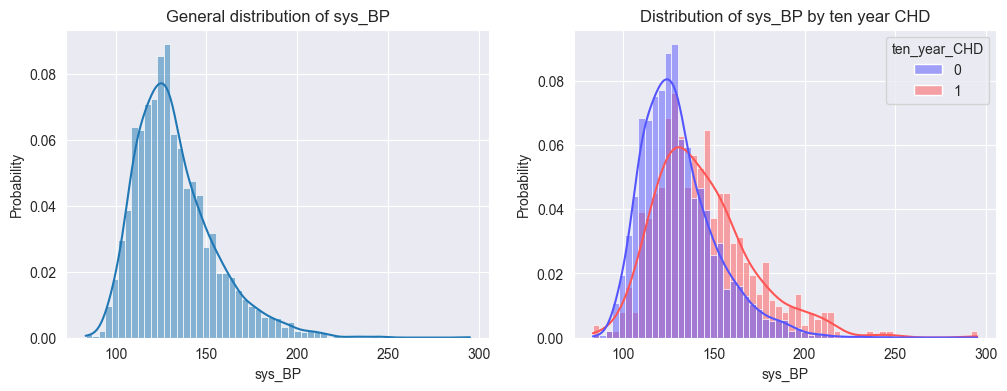

In [52]:
eda_graphs(df, 'sys_BP')

In [53]:
descr_cont('sys_BP')

General    CHD  non CHD
count   3390.0  511.0   2879.0
mean     132.6  143.9    130.6
std       22.3   27.1     20.7
min       83.5   83.5     83.5
1%        96.9   98.0     96.5
50%      128.5  139.0    127.0
99%      202.1  215.0    194.2
max      295.0  295.0    243.0

#### Diastolic Blood pressure

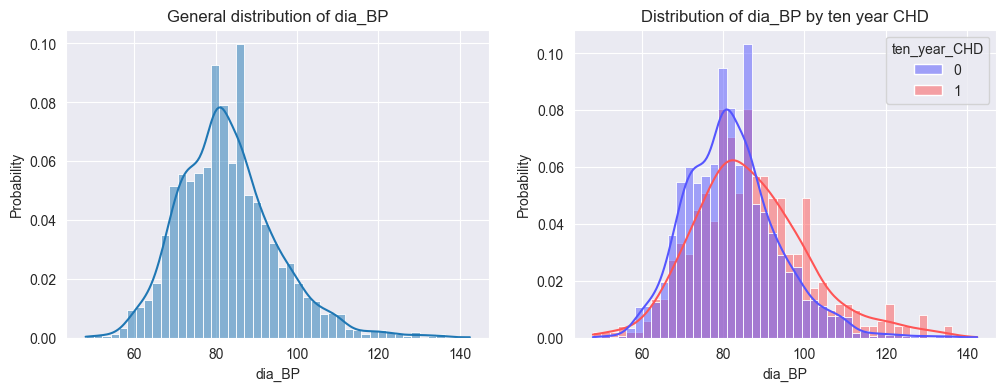

In [54]:
eda_graphs(df, 'dia_BP')

In [55]:
descr_cont('dia_BP')

General    CHD  non CHD
count   3390.0  511.0   2879.0
mean      82.9   86.8     82.2
std       12.0   14.0     11.5
min       48.0   48.0     50.0
1%        60.0   57.2     60.0
50%       82.0   85.0     81.0
99%      119.1  128.6    114.0
max      142.5  135.0    142.5

#### Body Mass Index

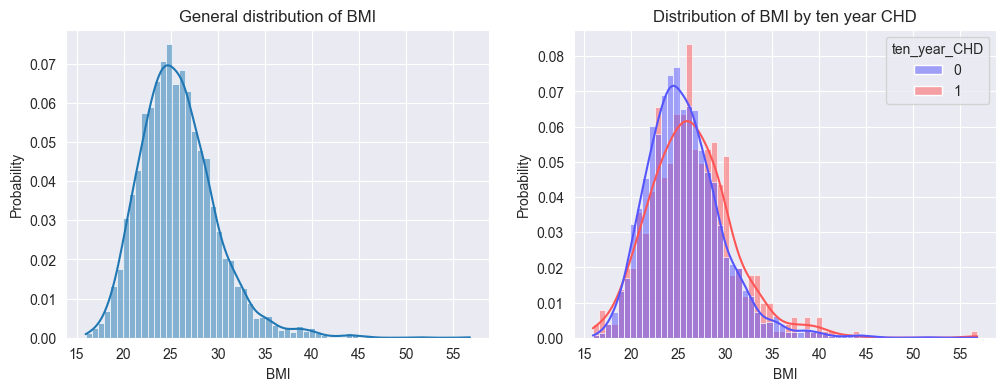

In [56]:
eda_graphs(df, 'BMI')

In [57]:
descr_cont('BMI')

General    CHD  non CHD
count   3376.0  504.0   2872.0
mean      25.8   26.5     25.7
std        4.1    4.6      4.0
min       16.0   16.0     16.5
1%        18.3   17.2     18.4
50%       25.4   26.2     25.2
99%       38.9   39.9     38.5
max       56.8   56.8     51.3

#### Heart Rate

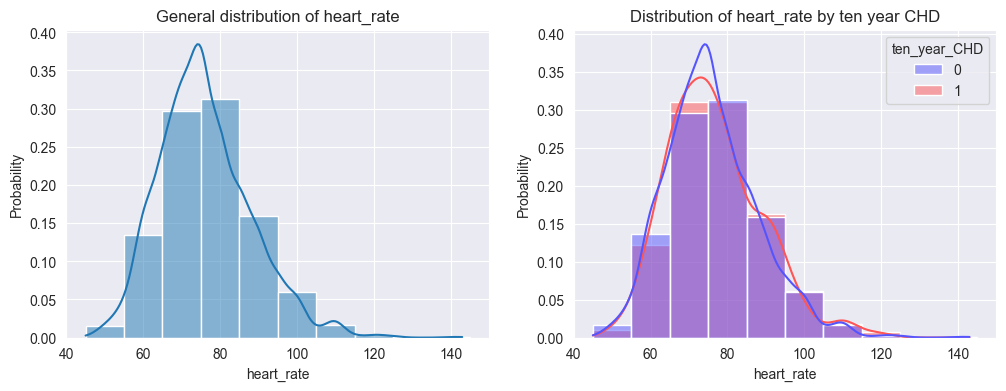

In [58]:
eda_graphs(df, 'heart_rate', binwidth=10)

In [59]:
descr_cont('heart_rate')

General    CHD  non CHD
count   3389.0  510.0   2879.0
mean      76.0   76.6     75.9
std       12.0   12.2     11.9
min       45.0   50.0     45.0
1%        52.9   55.0     52.8
50%       75.0   75.0     75.0
99%      110.0  110.0    110.0
max      143.0  120.0    143.0

#### Glucose level

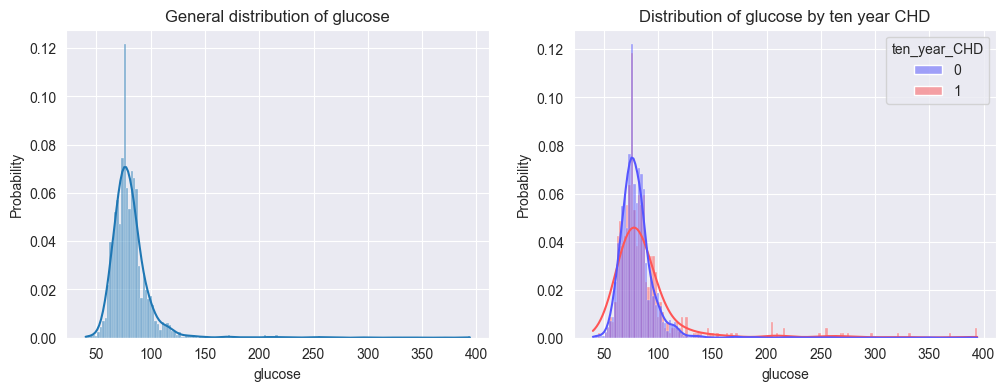

In [60]:
eda_graphs(df, 'glucose')

In [61]:
descr_cont('glucose')

General    CHD  non CHD
count   3086.0  472.0   2614.0
mean      82.1   90.0     80.7
std       24.2   42.4     18.9
min       40.0   45.0     40.0
1%        55.0   57.0     55.0
50%       78.0   79.5     78.0
99%      183.5  303.7    136.0
max      394.0  394.0    386.0

### Correlation Analysis

In [62]:
df = pd.get_dummies(df, columns=['education'])

In [63]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['age', 'cigs_per_day', 'BP_meds', 'prev_stroke', 'prev_hyp', 'diabetes', 'tot_chol', 'sys_BP', 'dia_BP', 'BMI', 'heart_rate', 'glucose', 'ten_year_CHD', 'sex', 'is_smoking', 'education_0.0', 'education_1.0', 'education_2.0', 'education_3.0', 'education_4.0']


age  cigs_per_day  BP_meds  prev_stroke  prev_hyp  diabetes  \
age            1.00          0.22     0.17         0.07      0.39      0.13   
cigs_per_day   0.22          1.00     0.00         0.00      0.15      0.04   
BP_meds        0.17          0.00     1.00         0.17      0.39      0.10   
prev_stroke    0.07          0.00     0.17         1.00      0.10      0.00   
prev_hyp       0.39          0.15     0.39         0.10      1.00      0.12   
diabetes       0.13          0.04     0.10         0.00      0.12      1.00   
tot_chol       0.22          0.00     0.08         0.00      0.15      0.11   
sys_BP         0.31          0.09     0.30         0.05      0.70      0.14   
dia_BP         0.24          0.11     0.29         0.06      0.81      0.07   
BMI            0.17          0.16     0.16         0.29      0.38      0.14   
heart_rate     0.03          0.08     0.12         0.00      0.20      0.04   
glucose        0.16          0.00     0.15         0.05      0.10      0.90   
ten_year_CHD   0.29          0.07     0.13         0.10      0.26      0.16   
sex            0.02          0.44     0.06         0.00      0.00      0.00   
is_smoking     0.29          0.97     0.05         0.06      0.18      0.08   
education_0.0  0.03          0.00     0.00         0.00      0.00      0.00   
education_1.0  0.31          0.03     0.00         0.03      0.13      0.09   
education_2.0  0.24          0.07     0.00         0.00      0.03      0.05   
education_3.0  0.07          0.06     0.00         0.00      0.08      0.01   
education_4.0  0.08          0.04     0.00         0.02      0.04      0.01   

               tot_chol  sys_BP  dia_BP   BMI  heart_rate  glucose  \
age                0.22    0.31    0.24  0.17        0.03     0.16   
cigs_per_day       0.00    0.09    0.11  0.16        0.08     0.00   
BP_meds            0.08    0.30    0.29  0.16        0.12     0.15   
prev_stroke        0.00    0.05    0.06  0.29        0.00     0.05   
prev_hyp           0.15    0.70    0.81  0.38        0.20     0.10   
diabetes           0.11    0.14    0.07  0.14        0.04     0.90   
tot_chol           1.00    0.20    0.10  0.11        0.06     0.11   
sys_BP             0.20    1.00    0.71  0.34        0.14     0.25   
dia_BP             0.10    0.71    1.00  0.47        0.18     0.21   
BMI                0.11    0.34    0.47  1.00        0.18     0.16   
heart_rate         0.06    0.14    0.18  0.18        1.00     0.07   
glucose            0.11    0.25    0.21  0.16        0.07     1.00   
ten_year_CHD       0.09    0.21    0.19  0.10        0.00     0.18   
sex                0.08    0.10    0.10  0.27        0.16     0.04   
is_smoking         0.05    0.14    0.16  0.21        0.09     0.10   
education_0.0      0.10    0.00    0.00  0.04        0.03     0.00   
education_1.0      0.00    0.13    0.09  0.19        0.00     0.07   
education_2.0      0.04    0.03    0.04  0.09        0.04     0.06   
education_3.0      0.01    0.08    0.08  0.11        0.04     0.01   
education_4.0      0.00    0.05    0.03  0.03        0.06     0.00   

               ten_year_CHD   sex  is_smoking  education_0.0  education_1.0  \
age                    0.29  0.02        0.29           0.03           0.31   
cigs_per_day           0.07  0.44        0.97           0.00           0.03   
BP_meds                0.13  0.06        0.05           0.00           0.00   
prev_stroke            0.10  0.00        0.06           0.00           0.03   
prev_hyp               0.26  0.00        0.18           0.00           0.13   
diabetes               0.16  0.00        0.08           0.00           0.09   
tot_chol               0.09  0.08        0.05           0.10           0.00   
sys_BP                 0.21  0.10        0.14           0.00           0.13   
dia_BP                 0.19  0.10        0.16           0.00           0.09   
BMI                    0.10  0.27        0.21           0.04           0.19   
heart_rate      

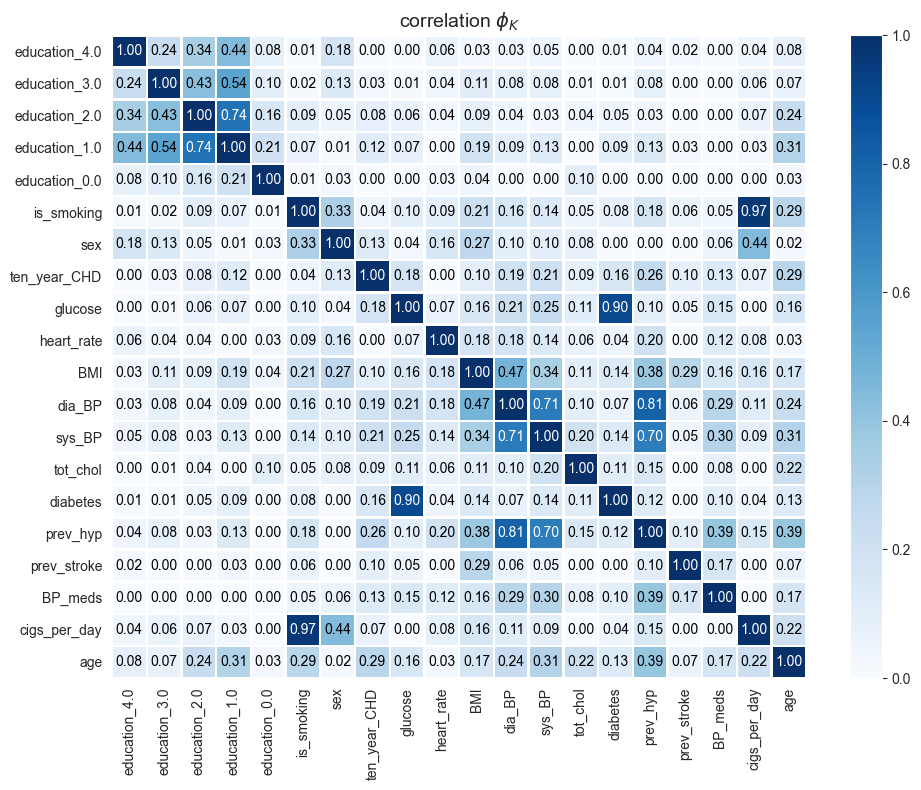

In [64]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

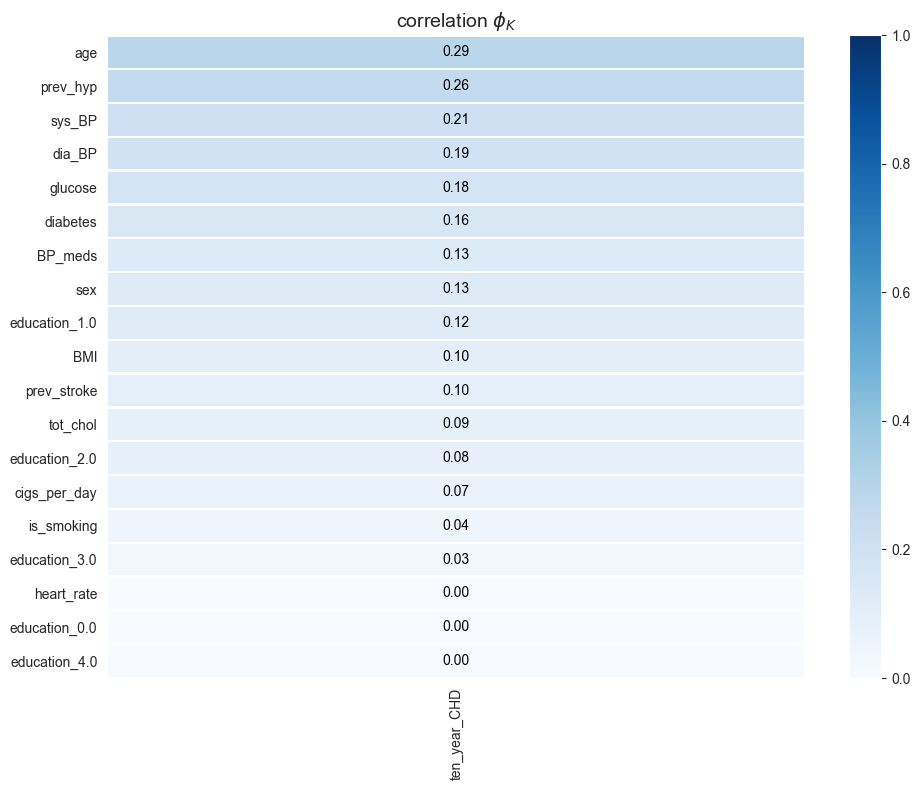

In [65]:
phik_overview = (
    phik_overview[['ten_year_CHD']]
    .drop(['ten_year_CHD'], axis=0)
    .sort_values(by='ten_year_CHD', ascending=True)
)


plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 8))
plt.tight_layout()

## Data Preparation for ML

### Dealing with Missing Data

In [66]:
df_initial = df.copy()

In [67]:
df[df['glucose'].isna()]['diabetes'].value_counts()

0    301
1      3
Name: diabetes, dtype: int64

In [68]:
df.query('diabetes == 0')['glucose'].median()

78.0

In [69]:
df.query('diabetes == 1')['glucose'].median()

150.0

In [70]:
df.loc[df.diabetes==0, 'glucose'] = df.loc[df.diabetes==0, 'glucose'].fillna(
    df.query('diabetes == 0')['glucose'].median()
)

df.loc[df.diabetes==1, 'glucose'] = df.loc[df.diabetes==1, 'glucose'].fillna(
    df.query('diabetes == 1')['glucose'].median()
)

In [71]:
df.dropna(inplace=True)

In [72]:
df.isna().sum()

age              0
cigs_per_day     0
BP_meds          0
prev_stroke      0
prev_hyp         0
diabetes         0
tot_chol         0
sys_BP           0
dia_BP           0
BMI              0
heart_rate       0
glucose          0
ten_year_CHD     0
sex              0
is_smoking       0
education_0.0    0
education_1.0    0
education_2.0    0
education_3.0    0
education_4.0    0
dtype: int64

In [73]:
1 - len(df)/len(df_initial)

0.03480825958702061

### Train/Test Split

In [74]:
X = df.drop('ten_year_CHD', axis = 1)
y = df['ten_year_CHD']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

In [76]:
len(X_train), len(X_test)

(2617, 655)

In [77]:
y_train.value_counts(), y_test.value_counts()

(0    2224
 1     393
 Name: ten_year_CHD, dtype: int64,
 0    560
 1     95
 Name: ten_year_CHD, dtype: int64)

### Oversampling  Imbalance Data

In [78]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size = 0.2) 

In [79]:
len(X_train_sm), len(X_test_sm)

(4454, 1114)

In [80]:
y_train_sm.value_counts(), y_test_sm.value_counts()

(0    2229
 1    2225
 Name: ten_year_CHD, dtype: int64,
 1    559
 0    555
 Name: ten_year_CHD, dtype: int64)

### Data Standartization

In [81]:
scaler = StandardScaler()
scaler.fit(X_train) 

X_train_st = scaler.transform(X_train) 
X_test_st = scaler.transform(X_test) 

X_train_st_sm = scaler.transform(X_train_sm) 
X_test_st_sm = scaler.transform(X_test_sm) 

## Machine Learning

In [82]:
def ml(model, grid_values, X_train, X_test, y_train, y_test):
    
    grid = GridSearchCV(model, param_grid = grid_values, scoring='roc_auc')
    grid.fit(X_train, y_train)

    model = grid.best_estimator_
    model.fit(X_train, y_train)
    
    y_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{type(model).__name__} ROC curve')
    plt.show()

    print(
        'ROC AUC score: {:.2f}'.format(
           roc_auc_score(y_test, y_proba)
        )
    )


    threshold = thresholds[np.argmin((1 - tpr) ** 2 + fpr ** 2)] 
    y_pred = [0 if i < threshold else 1 for i in y_proba]

    print(
        'Accuracy: {:.2f}'.format(
            balanced_accuracy_score(y_test, y_pred)
        )
    )

    print(
        'Precision: {:.2f}'.format(
            precision_score(y_test, y_pred)
        )
    )
    print(
        'Recall: {:.2f}'.format(
            recall_score(y_test, y_pred)
        )
    )
    print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print (
        'Specificity {:.2f}' .format(1-(fp / (fp + tn)))
    )
    
    
    if isinstance(model, LogisticRegression):
        importances = pd.DataFrame({'Sign': X.columns, 'Weight': model.coef_[0]})
        display(importances.sort_values(by='Weight', ascending=False, ignore_index=True))
    else:
        importances = pd.DataFrame({'Sign': X.columns, 'Importance': model.feature_importances_ })
        display(importances.sort_values(by='Importance', ascending=False, ignore_index=True))

### Logistic Regression

In [83]:
lr = LogisticRegression(solver='liblinear', penalty='l1')
lr_parameters = {
    'C':[0.001, .009, 0.01, .09, 1, 5, 10, 25], 
    'fit_intercept': [True, False], 
    'intercept_scaling': [0.001, .009, 0.01, .09, 1, 5, 10, 25] 
}

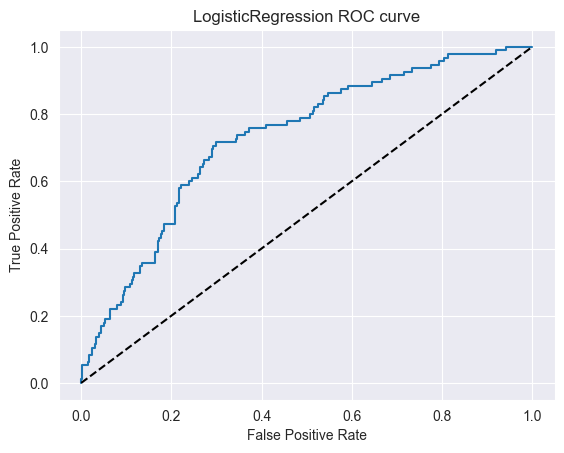

ROC AUC score: 0.73
Accuracy: 0.71
Precision: 0.29
Recall: 0.72
F1: 0.41
Specificity 0.70


Sign    Weight
0             age  0.535271
1          sys_BP  0.327502
2    cigs_per_day  0.273534
3         glucose  0.160893
4             sex  0.156008
5      is_smoking  0.065908
6        tot_chol  0.046851
7     prev_stroke  0.040808
8             BMI  0.021896
9         BP_meds  0.010812
10  education_3.0  0.000132
11         dia_BP  0.000000
12     heart_rate  0.000000
13       diabetes  0.000000
14       prev_hyp  0.000000
15  education_0.0  0.000000
16  education_1.0  0.000000
17  education_4.0  0.000000
18  education_2.0 -0.044218

In [84]:
ml(lr, lr_parameters, X_train_st, X_test_st, y_train, y_test)

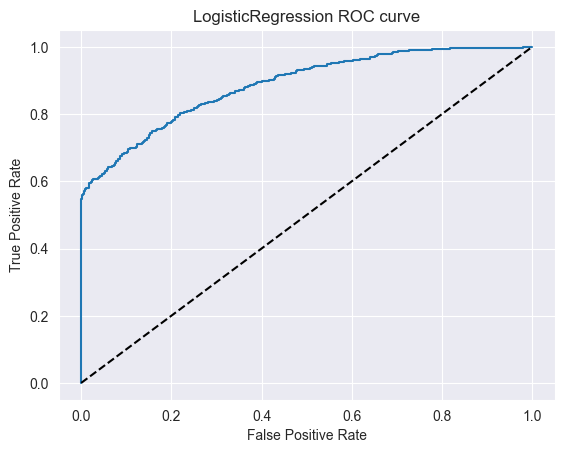

ROC AUC score: 0.89
Accuracy: 0.79
Precision: 0.80
Recall: 0.77
F1: 0.79
Specificity 0.81


Sign    Weight
0             age  0.532328
1    cigs_per_day  0.413768
2          sys_BP  0.319017
3         glucose  0.194832
4         BP_meds  0.078954
5        tot_chol  0.072176
6          dia_BP  0.000041
7             BMI  0.000000
8        diabetes  0.000000
9      heart_rate -0.003795
10    prev_stroke -0.015441
11            sex -0.028287
12       prev_hyp -0.115469
13     is_smoking -0.182381
14  education_0.0 -0.805821
15  education_4.0 -1.611447
16  education_3.0 -1.937407
17  education_1.0 -2.180044
18  education_2.0 -2.296669

In [85]:
ml(lr, lr_parameters, X_train_st_sm, X_test_st_sm, y_train_sm, y_test_sm)

### Decision Tree Classifier

In [86]:
dtc = DecisionTreeClassifier()
dtc_parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter':['best', 'random'], 
    'max_depth': range (1, 20, 4),
    'min_samples_split': range (2, 8), 
    'min_samples_leaf': range (1, 10, 2) 
}

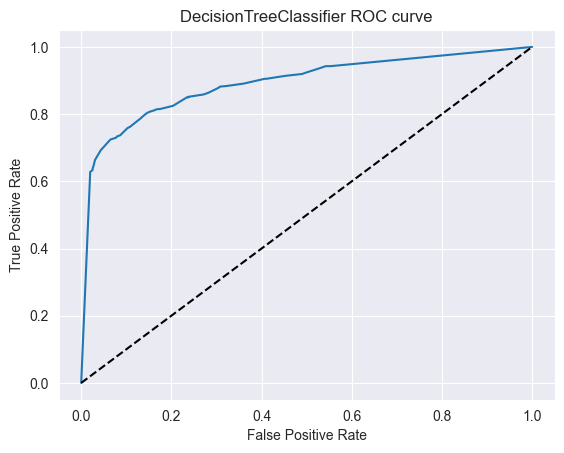

ROC AUC score: 0.89
Accuracy: 0.83
Precision: 0.85
Recall: 0.80
F1: 0.82
Specificity 0.85


Sign  Importance
0   education_4.0    0.183548
1   education_1.0    0.136826
2             age    0.110731
3   education_3.0    0.103690
4   education_2.0    0.103572
5   education_0.0    0.050184
6    cigs_per_day    0.041506
7        tot_chol    0.036685
8          dia_BP    0.034912
9         glucose    0.034337
10         sys_BP    0.034131
11     heart_rate    0.030390
12            sex    0.027619
13            BMI    0.019806
14       prev_hyp    0.017882
15     is_smoking    0.016335
16        BP_meds    0.013512
17       diabetes    0.004334
18    prev_stroke    0.000000

In [87]:
ml(dtc, dtc_parameters, X_train_sm, X_test_sm, y_train_sm, y_test_sm)

### Random Forest Classifier

In [88]:
rfc = RandomForestClassifier()
rfc_parameters = {
    'n_estimators': [50, 65, 80, 95,120],
    'max_depth': [3, 5, 7, 9, 12]
}

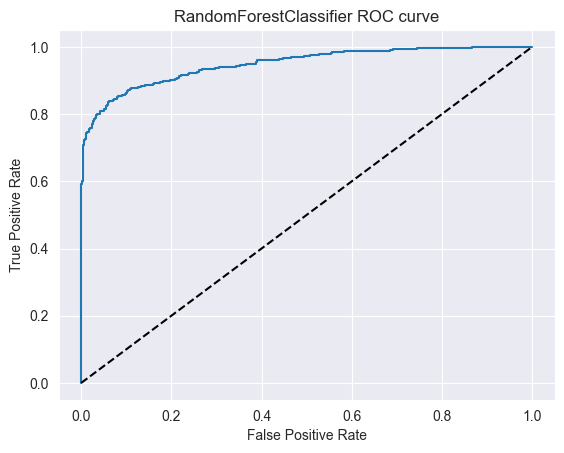

ROC AUC score: 0.95
Accuracy: 0.88
Precision: 0.90
Recall: 0.87
F1: 0.88
Specificity 0.90


Sign  Importance
0             age    0.120184
1   education_2.0    0.096976
2          sys_BP    0.089667
3   education_1.0    0.085993
4   education_3.0    0.078575
5        tot_chol    0.074629
6         glucose    0.069309
7          dia_BP    0.067802
8    cigs_per_day    0.065038
9      heart_rate    0.064755
10            BMI    0.052819
11  education_4.0    0.050209
12     is_smoking    0.028869
13        BP_meds    0.018686
14  education_0.0    0.012902
15            sex    0.009913
16       prev_hyp    0.009464
17       diabetes    0.003356
18    prev_stroke    0.000854

In [89]:
ml(rfc, rfc_parameters, X_train_sm, X_test_sm, y_train_sm, y_test_sm)

### Cat Boost Classifier

In [90]:
cbc = CatBoostClassifier(logging_level='Silent')

In [91]:
cbc_parameters = {
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.02, 0.03, 0.04],
    'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

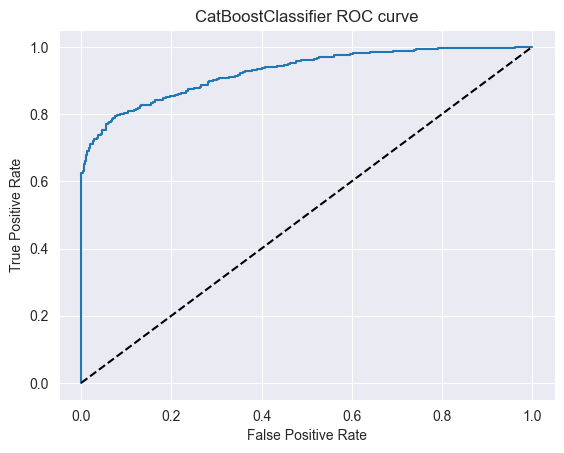

ROC AUC score: 0.93
Accuracy: 0.86
Precision: 0.90
Recall: 0.80
F1: 0.85
Specificity 0.91


Sign  Importance
0   education_2.0   20.298053
1   education_1.0   19.773995
2   education_3.0   15.310702
3   education_4.0   10.521981
4             age    6.331661
5    cigs_per_day    5.863444
6        tot_chol    3.277840
7          sys_BP    2.871656
8         glucose    2.752954
9      is_smoking    2.699134
10     heart_rate    2.608884
11  education_0.0    1.942348
12            BMI    1.697372
13         dia_BP    1.603515
14        BP_meds    1.288268
15            sex    0.737906
16       prev_hyp    0.390221
17       diabetes    0.029643
18    prev_stroke    0.000423

In [92]:
ml(cbc, cbc_parameters, X_train_sm, X_test_sm, y_train_sm, y_test_sm)